In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Kết luận: <b> LSTM có MAE thấp nhất (8.11), dự đoán gần đúng với giá trị thực tế nhất so với các mô hình khác. Do khả năng học các chuỗi quan sát dài hạn của mô hình, LSTM đã trở thành một phương pháp tiếp cận theo xu hướng để dự báo chuỗi thời gian.. <div>

# 1. Đọc dữ liệu

Đọc dữ liệu và gán biến Date làm index

In [57]:
df = pd.read_csv('NFLX.csv',  index_col=0)
df.drop(columns = ['Open', 'Low', 'Close', 'Adj Close', 'Volume'],inplace=True)

Chuyển index về dạng datetime

In [58]:
df.index = pd.to_datetime(df.index)

Vì dữ liệu theo ngày nên gán biến Date thành "D" (Daily frequency)

In [59]:
df.index.asfreq = 'D'
df = df.sort_index()

# 2. Kiểm tra dữ liệu

In [60]:
df.head(5)

,High
Date,
2018-02-05,267.90
2018-02-06,266.70
2018-02-07,272.45
2018-02-08,267.62
2018-02-09,255.80


In [61]:
df.tail(5)

,High
Date,
2022-01-31,427.70
2022-02-01,458.48
2022-02-02,451.98
2022-02-03,429.26
2022-02-04,412.77


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1009 entries, 2018-02-05 to 2022-02-04
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    1009 non-null   float64
dtypes: float64(1)
memory usage: 15.8 KB


In [63]:
df.isnull().sum()

High    0
dtype: int64

Kiểm tra xem ngày có bị thiếu hay không?

In [64]:
full_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = full_dates.difference(df.index)

print('Số ngày bị thiếu:',len(missing_dates))

Số ngày bị thiếu: 452


Thêm dữ liệu vào ngày bị thiếu, áp dụng phương pháp interpolate

In [65]:
full_df = pd.DataFrame(index=full_dates)
full_df['High'] = df['High']
full_df['High'].interpolate(method='linear', inplace=True)

full_df.head(5)

,High
2018-02-05,267.90
2018-02-06,266.70
2018-02-07,272.45
2018-02-08,267.62
2018-02-09,255.80


Tạo biến time_series bắt đầu từ năm 2018

In [66]:
time_series = full_df[full_df.index.year >=int(2018)]
time_series.head()

,High
2018-02-05,267.90
2018-02-06,266.70
2018-02-07,272.45
2018-02-08,267.62
2018-02-09,255.80


# 3. Vẽ biểu đồ chuỗi thời gian ban đầu

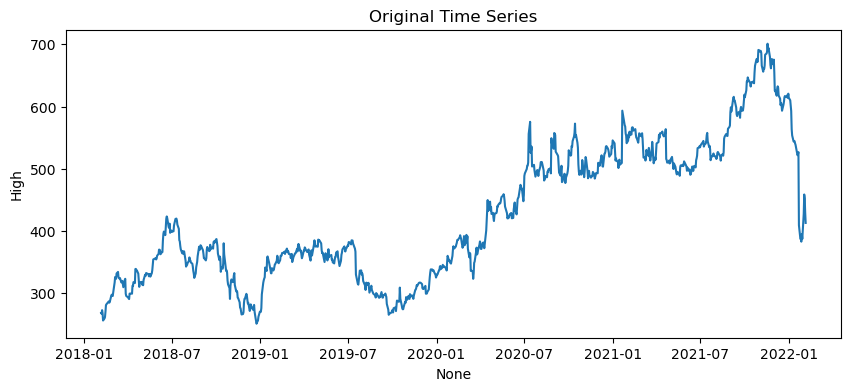

In [67]:
plt.figure(figsize=(10, 4))
sns.lineplot(time_series, x= time_series.index, y = 'High')
plt.title('Original Time Series')
plt.xticks(rotation = 0)
plt.show()

# 4. Phân tích chuỗi thời gian

<Figure size 1500x1600 with 0 Axes>

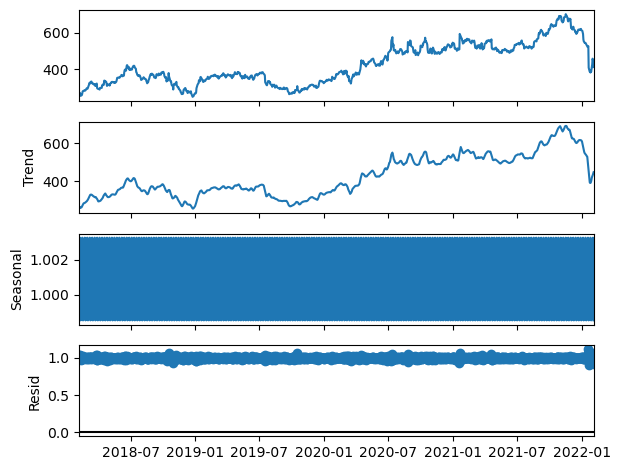

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(15,16))
result = seasonal_decompose(time_series, model='multiplicative',extrapolate_trend='freq')
result.plot()
plt.show()

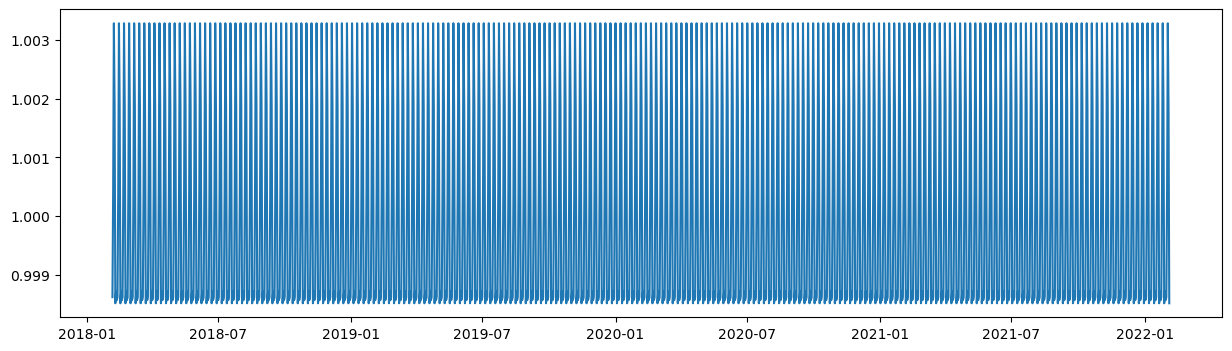

In [69]:
plt.figure(figsize=(15,4))
plt.plot(result.seasonal)

<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Ta thấy dữ liệu có trend đi lên, và có seasonal <b> <div>

# 5. Chia tách dữ liệu

In [70]:
train_size = int(0.85*time_series.size)
train = time_series.iloc[:train_size]
test = time_series.iloc[train_size:]

# 6. Time series áp dụng SARIMA

Sử dụng model SARIMA vì dữ liệu có seasonal

In [71]:
# Kiểm tra tính dừng với ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if (result[1]<0.05): 
        print('Data is stationary')
    else:
        print('Data is not stationary')

## Xác định p,d,q

Kiểm tra tính dừng của dữ liệu hiện tại

ADF Statistic: -1.8493324619366518
p-value: 0.3562588724397656
Data is not stationary


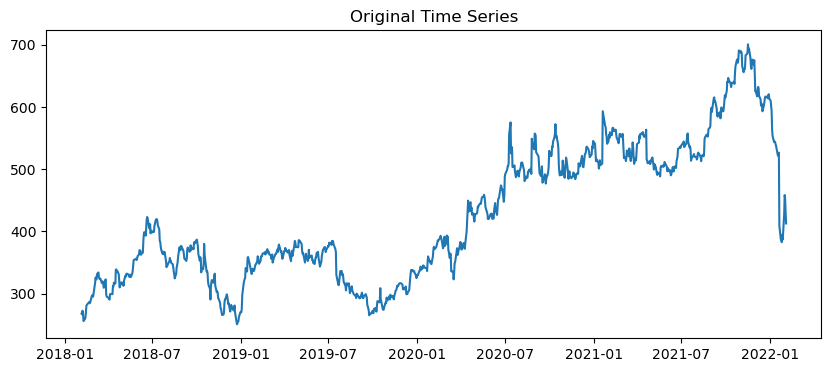

In [72]:
adf_test(time_series)

# Vẽ biểu đồ chuỗi thời gian ban đầu
plt.figure(figsize=(10, 4))
plt.plot(time_series)
plt.title('Original Time Series')
plt.show()

Vì dữ liệu chưa có tính dừng, ta sai phân lần thứ nhất và kiểm tra lại tính dừng

ADF Statistic: -34.388587606401266
p-value: 0.0
Data is stationary


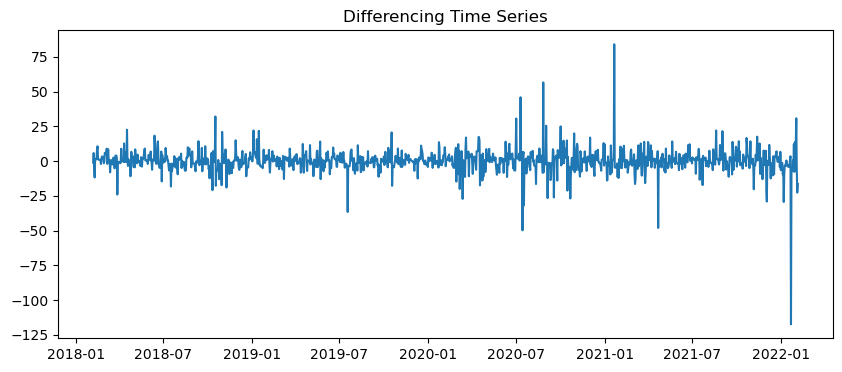

In [73]:
# Differencing lần thứ nhất 
diff_series = time_series.diff(1).dropna()

# Kiểm tra tính dừng sau khi differencing
adf_test(diff_series)

plt.figure(figsize=(10, 4))
plt.plot(diff_series)
plt.title('Differencing Time Series')
plt.show()

<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Sau khi sai phân lần thứ nhất, dữ liệu có tính dừng => d = 1 <b> <div>

Vẽ biểu đồ ACF và PACF của chuỗi đã sai phân để tính p & q (sau khi dữ liệu đã có tính dừng)

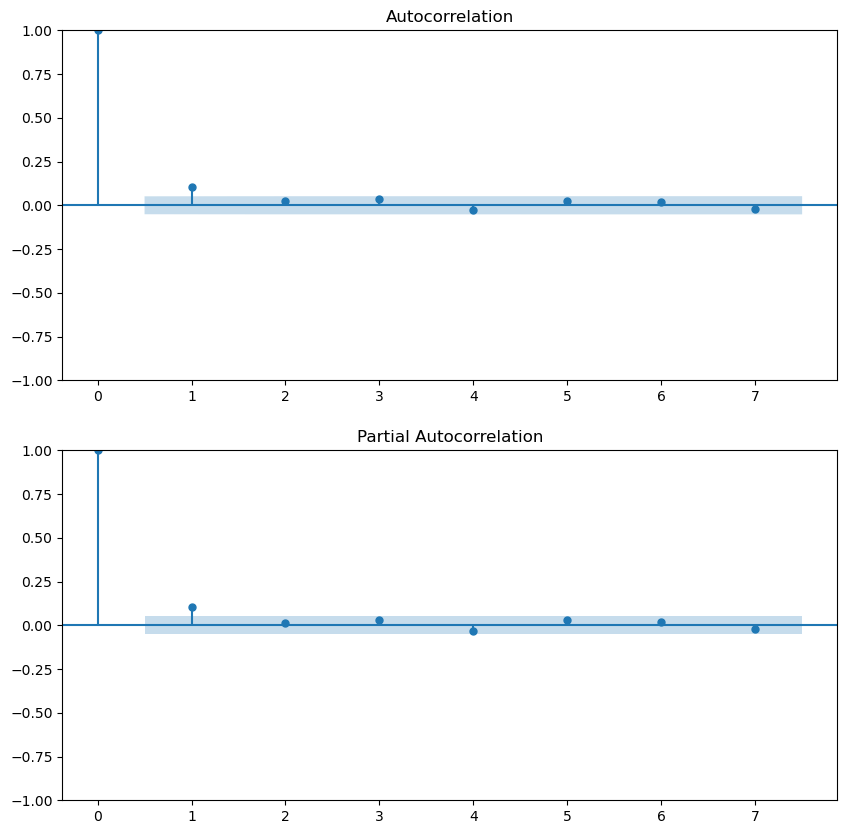

In [74]:
# Vẽ biểu đồ ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_acf(diff_series, ax=ax[0], lags = 7, alpha= 0.05)  
plot_pacf(diff_series, ax=ax[1], lags= 7, alpha =0.05)
plt.show()

<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Dựa vào biểu đồ, ta chọn p = 2 và q = 2 <b> <div>

## Xác định P,D,Q,m

Xét mùa vụ m = 7

ADF Statistic: -6.780131544712368
p-value: 2.5117379350432875e-09
Data is stationary


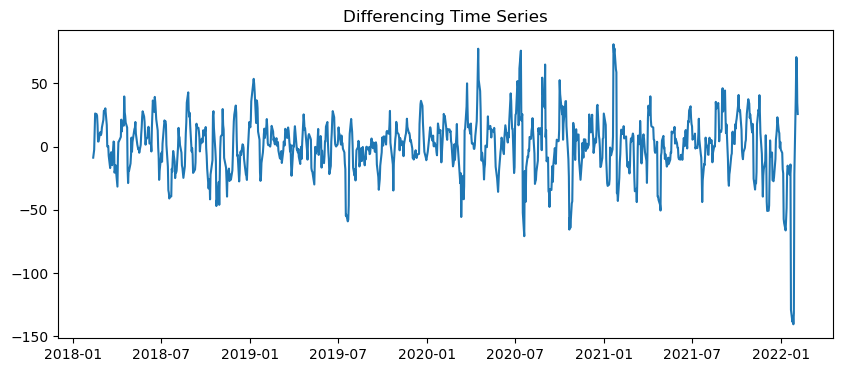

In [75]:
# Differencing lần thứ nhất 
seasonal_diff_series = time_series.diff(7).dropna()

# Kiểm tra tính dừng sau khi differencing
adf_test(seasonal_diff_series)

# Vẽ biểu đồ chuỗi thời gian ban đầu
plt.figure(figsize=(10, 4))
plt.plot(seasonal_diff_series)
plt.title('Differencing Time Series')
plt.show()


<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Với m = 7, dữ liệu đã có tính dừng sau khi sai phân nên xác định D = 1 <b> <div>

Tiếp tục vẽ biểu đồ ACF và PACF của chuỗi đã sai phân mùa vụ để tính P & Q (sau khi dữ liệu đã có tính dừng)

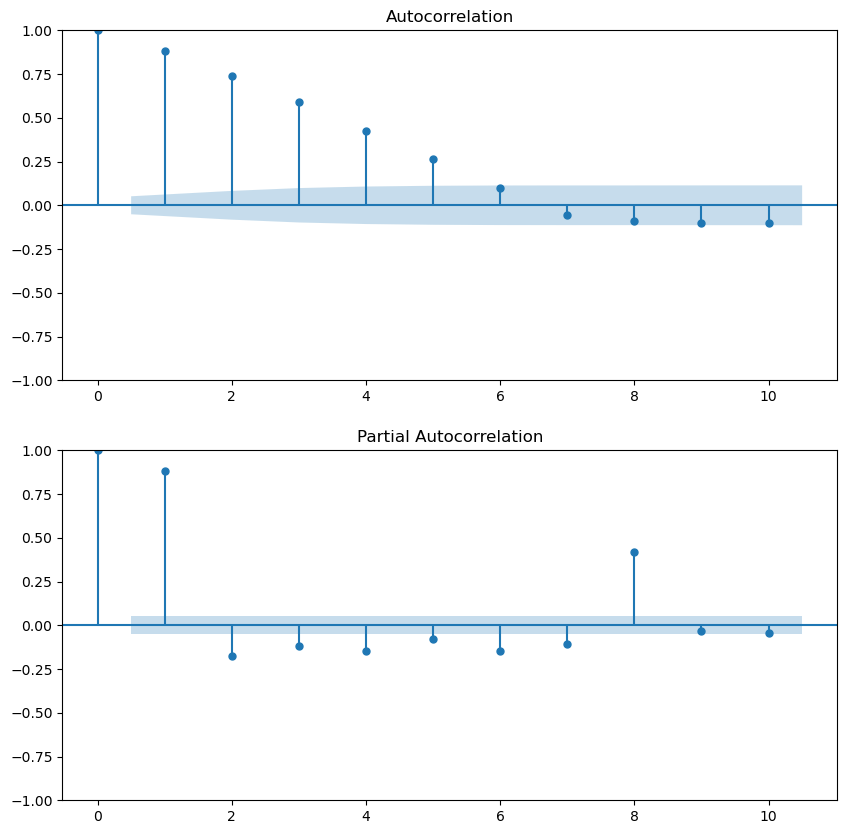

In [76]:
# Vẽ biểu đồ ACF và PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plot_acf(seasonal_diff_series, ax=ax[0], lags = 10, alpha= 0.05)  
plot_pacf(seasonal_diff_series, ax=ax[1], lags= 10, alpha =0.05)
plt.show()

<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Dựa vào biểu đồ, ta chọn P = 9 và q = 6 <b> <div>

## Áp dụng mô hình Sarima

In [77]:
p, d, q = 2, 1, 2
P, D, Q, m = 9,1,6,7

model = sm.tsa.SARIMAX(train, order=(p, d, q),seasonal_order = (P, D, Q,m))
model_fit = model.fit()
print(model_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46732D+00    |proj g|=  4.90150D-02

At iterate    5    f=  3.37239D+00    |proj g|=  9.38478D-02

At iterate   10    f=  3.35322D+00    |proj g|=  4.25955D-03

At iterate   15    f=  3.35294D+00    |proj g|=  5.43397D-03

At iterate   20    f=  3.35280D+00    |proj g|=  5.40590D-03

At iterate   25    f=  3.35187D+00    |proj g|=  1.68492D-02

At iterate   30    f=  3.35112D+00    |proj g|=  3.51443D-03

At iterate   35    f=  3.35071D+00    |proj g|=  3.82061D-03

At iterate   40    f=  3.35021D+00    |proj g|=  7.26568D-03

At iterate   45    f=  3.34962D+00    |proj g|=  8.31617D-03

At iterate   50    f=  3.34929D+00    |proj g|=  4.84584D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

Dự báo cho tập test

In [78]:
forecast = pd.DataFrame(model_fit.forecast(steps = int(test.size)))
forecast.head()

,predicted_mean
2021-06-30,538.463601
2021-07-01,537.322837
2021-07-02,536.692563
2021-07-03,537.323966
2021-07-04,537.976252


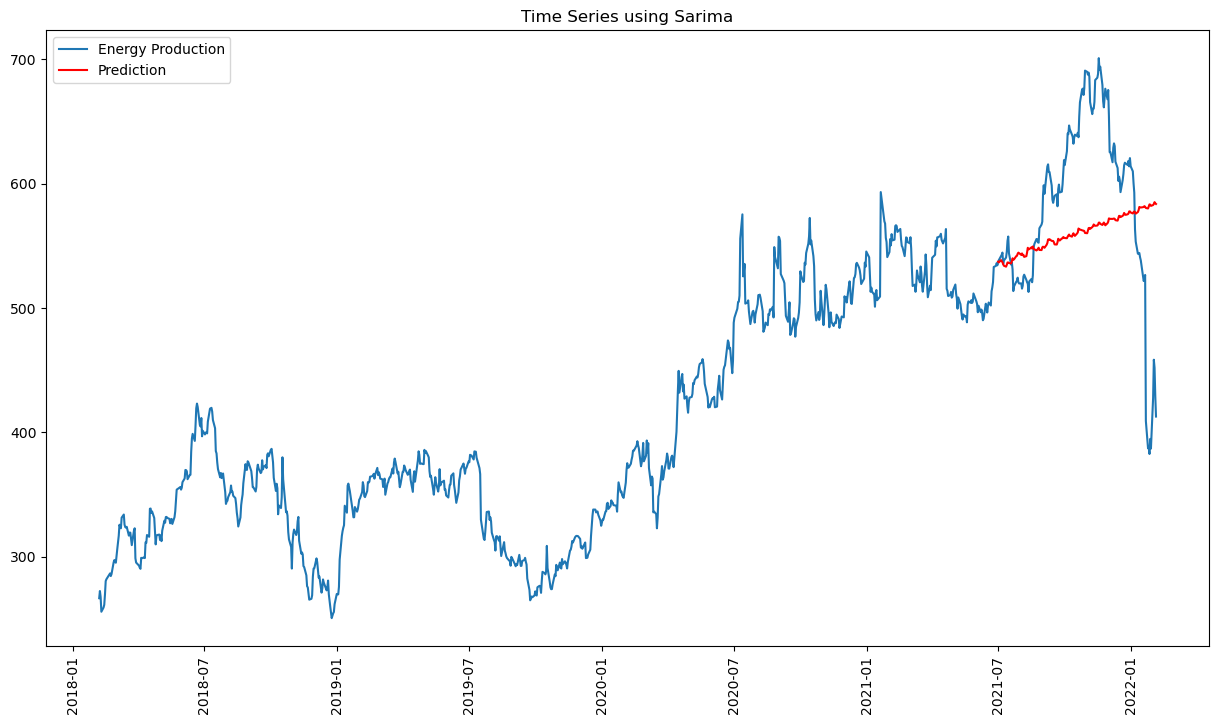

In [79]:
plt.figure(figsize=(15,8))
plt.plot(time_series.iloc[1:], label='Energy Production')
plt.plot(forecast.iloc[1:], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.title('Time Series using Sarima')
plt.legend()
plt.show()

Tính MAE

In [80]:
from sklearn import metrics

mae_sarima = metrics.mean_absolute_error(test, forecast)
mse_sarima = metrics.mean_squared_error(test, forecast)

mae_models = []
model_names = []
mae_models.append(mae_sarima)
model_names.append('Sarima')

print('MAE', mae_sarima)
print('MSE', mse_sarima)


MAE 59.23945540888018
MSE 5757.2400997244085


<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Ta thấy mae ~ 60 là khá lớn. Nhìn vào biểu đồ, ta thấy phần dự báo chưa được chính xác. Cùng thử các thuật toán khác để so sánh độ hiệu quả <b> <div>

# 7. Time series áp dụng Auto arima

In [81]:
from pmdarima import auto_arima

Xác định các tham số để xây dựng mô hình auto arima

In [82]:
auto_model = auto_arima(train, max_p=5, max_q=9, start_P=0, start_Q=0, max_P=5, max_Q=5,
                        m=7, d=1, D=1, seasonal=True,
                        trace=True, stepwise=True, 
                        error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,1,0)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9217.002, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=8873.031, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.58 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=9211.021, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8689.679, Time=0.50 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=8586.320, Time=1.33 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=8535.173, Time=1.13 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=8504.430, Time=2.57 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=22.89 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=inf, Time=13.99 sec
 ARIMA(0,1,0)(5,1,0)[7]             : AIC=8515.558, Time=1.68 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=8506.272, Time=2.57 sec
 ARIMA(1,1,1)(5,1,0)[7]             : AIC=8506.244, Time=3.58 sec
 ARIMA(0,1,1)(5,1,0)[7]             : AIC=8504.807,

In [83]:
auto_model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(5, 1, 0, 7),
      suppress_warnings=True, with_intercept=False)

Dự đoán cho tập test

In [84]:
auto_arima_predict = auto_model.predict(n_periods=len(test))

In [85]:
auto_arima_predict = pd.DataFrame(auto_arima_predict,index = test.index,columns=['Prediction'])
auto_arima_predict.head() 

,Prediction
2021-06-30,533.777805
2021-07-01,534.794049
2021-07-02,539.611270
2021-07-03,539.626836
2021-07-04,539.642353


Tính MAE

In [86]:
from sklearn import metrics
mae_autoarima = metrics.mean_absolute_error(test, auto_arima_predict)
mse_autoarima = metrics.mean_squared_error(test, auto_arima_predict)

mae_models.append(mae_autoarima)
model_names.append('Auto Arima')

print('MAE', mae_autoarima)
print('MSE', mse_autoarima)

MAE 86.59250789501169
MSE 18580.653649658565


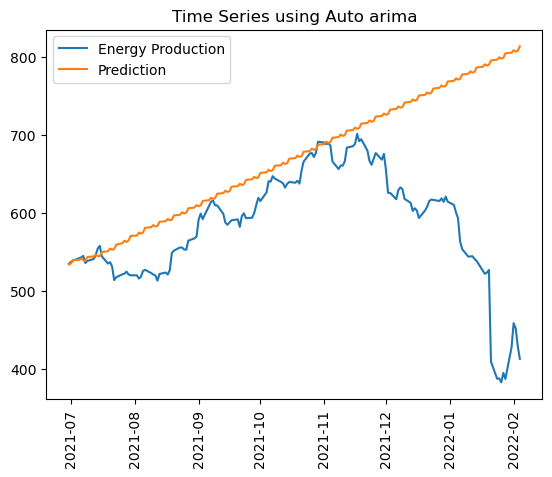

In [87]:
plt.plot(test, label='Energy Production')
plt.plot(auto_arima_predict, label='Prediction')
plt.xticks(rotation='vertical')
plt.title('Time Series using Auto arima')
plt.legend()
plt.show()

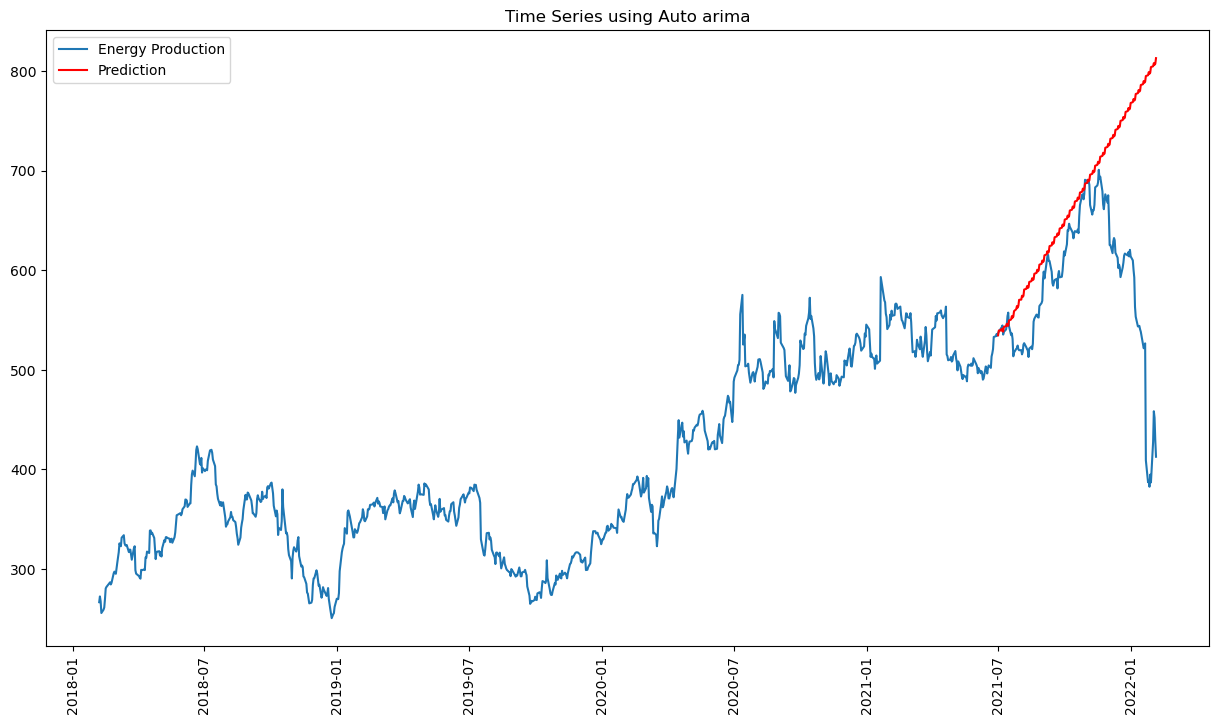

In [88]:
plt.figure(figsize=(15,8))
plt.plot(time_series.iloc[1:], label='Energy Production')
plt.plot(auto_arima_predict.iloc[1:], label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.title('Time Series using Auto arima')
plt.legend()
plt.show()

<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Ta thấy mae ~ 86 là khá lớn. Nhìn vào biểu đồ, model Auto Arima dự đoán đúng phần xu hướng đi lên, nhưng khi giá cổ phiếu giảm thì model chưa dự đoán tốt  <b> <div>

In [89]:
mae_comparison = pd.DataFrame(
    {
        'model_name': model_names,
        'mae': mae_models
    }
)
mae_comparison

,model_name,mae
0,Sarima,59.239455
1,Auto Arima,86.592508


<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Đối với tập dữ liệu này, Auto Arima kém hiệu quả hơn model Sarima <b> <div>

# 8. Time series áp dụng Machine learning (Random forest & XGboost)

### Scale & Chia tách dữ liệu

Scale dữ liệu

In [90]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
time_series = scaler.fit_transform(time_series)

Tạo function để xác định X, y cho tập dữ liệu

In [91]:
def create_dataset(data,time_steps):
    X,y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:(i+time_steps)])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

def train_test_split_series(X,y,train_size):
    train_size = int(len(X)*train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test

Xác định X, y cho tập dữ liệu

In [92]:
X,y = create_dataset(np.array(time_series),7)

In [93]:
X.shape

(1454, 7, 1)

Chia tách dữ liệu X,y thành X_train, X_test, y_train, y_test

In [94]:
X_train, X_test, y_train, y_test = train_test_split_series(X,y,0.85)

In [95]:
print('X_train shape', X_train.shape)
print('X_test shape', X_test.shape)
print('y_train shape', y_train.shape)
print('y_test shape', y_test.shape)

X_train shape (1235, 7, 1)
X_test shape (219, 7, 1)
y_train shape (1235, 1)
y_test shape (219, 1)


X_train và X_test được chuyển đổi thành ma trận 2D

y_train và y_test được chuyển thành vector 1 chiều (flatten) 

In [96]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)

y_train_flattened = y_train.reshape(-1)
y_test_flattened = y_test.reshape(-1)

print(y_train_flattened.shape, y_test_flattened.shape)

X_train_reshaped shape: (1235, 7)
X_test_reshaped shape: (219, 7)
(1235,) (219,)


### Random Forest

Áp dụng model RandomForest để dự báo giá cổ phiếu

In [97]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train_reshaped, y_train)

RandomForestRegressor(n_jobs=-1)

Dùng model để dự đoán

In [98]:
y_pred_forest = model.predict(X_test_reshaped)

Đánh giá model bằng các chỉ số MAE, MSE

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_forest = mean_squared_error(y_test_flattened, y_pred_forest)
mae_forest = mean_absolute_error(y_test_flattened, y_pred_forest)

print('mse before inverse:', mse_forest)
print('mae before inverse:', mae_forest)

mse before inverse: 0.016515622125066215
mae before inverse: 0.09346430270273048


In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_actual = scaler.inverse_transform(y_pred_forest.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

mse_forest = mean_squared_error(y_test_actual, y_pred_actual)
mae_forest = mean_absolute_error(y_test_actual, y_pred_actual)

mae_models.append(mae_forest)
model_names.append('Random Forest')

print('mse after inverse:', mse_forest)
print('mae after inverse:', mae_forest)


mse after inverse: 3349.4691699020987
mae after inverse: 42.09071407914766


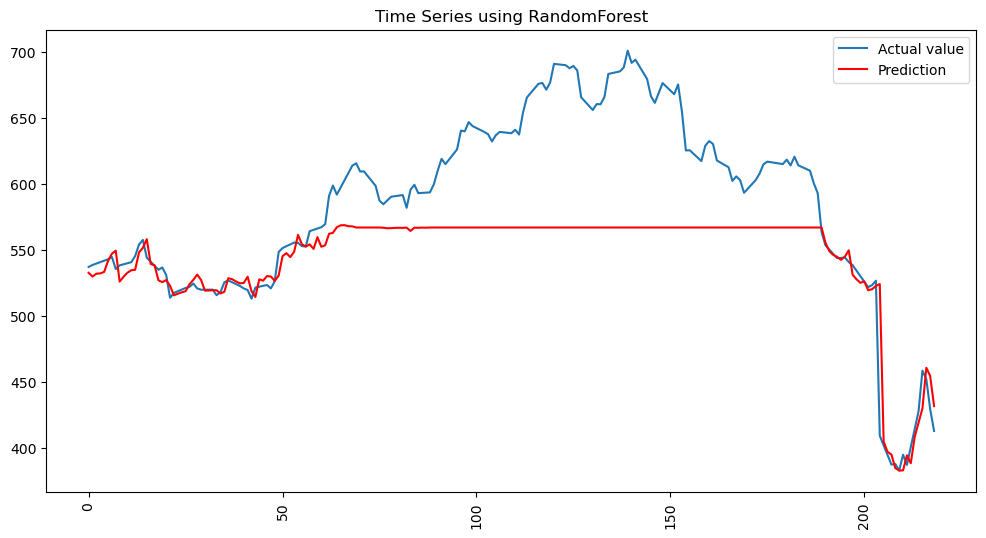

In [101]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label = 'Actual value')
plt.plot(y_pred_actual, label = 'Prediction', color = 'red')
plt.xticks(rotation = 'vertical')
plt.title('Time Series using RandomForest')
plt.legend()
plt.show()

In [102]:
mae_comparison = pd.DataFrame(
    {
        'model_name': model_names,
        'mae': mae_models
    }
)
mae_comparison

,model_name,mae
0,Sarima,59.239455
1,Auto Arima,86.592508
2,Random Forest,42.090714


<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Nhìn vào chỉ số MAE, RandomForest cho kết quả tốt hơn Sarima và Autoarima. Tuy nhiên, khi nhìn vào biểu đồ so sánh phần dự đoán tập dữ liệu test và prediction, phần đỉnh đồi dự đoán bị sai số nhiều  <b> <div>

### XGBoost

In [103]:
import xgboost as xgb

In [104]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train_reshaped, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [105]:
y_pred = xgb_model.predict(X_test_reshaped)

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_xgb = mean_squared_error(y_test_flattened, y_pred)
mae_xgb = mean_absolute_error(y_test_flattened, y_pred)

print('mse before inverse:', mse_xgb)
print('mae before inverse:', mae_xgb)


mse before inverse: 0.020620782750170815
mae before inverse: 0.10643160651458256


In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

mse_xgb = mean_squared_error(y_test_actual, y_pred_actual)
mae_xgb = mean_absolute_error(y_test_actual, y_pred_actual)

mae_models.append(mae_xgb)
model_names.append('XGBoost')

print('mse after inverse:', mse_xgb)
print('mae after inverse:', mae_xgb)

mse after inverse: 4182.0198027323695
mae after inverse: 47.930402302502486


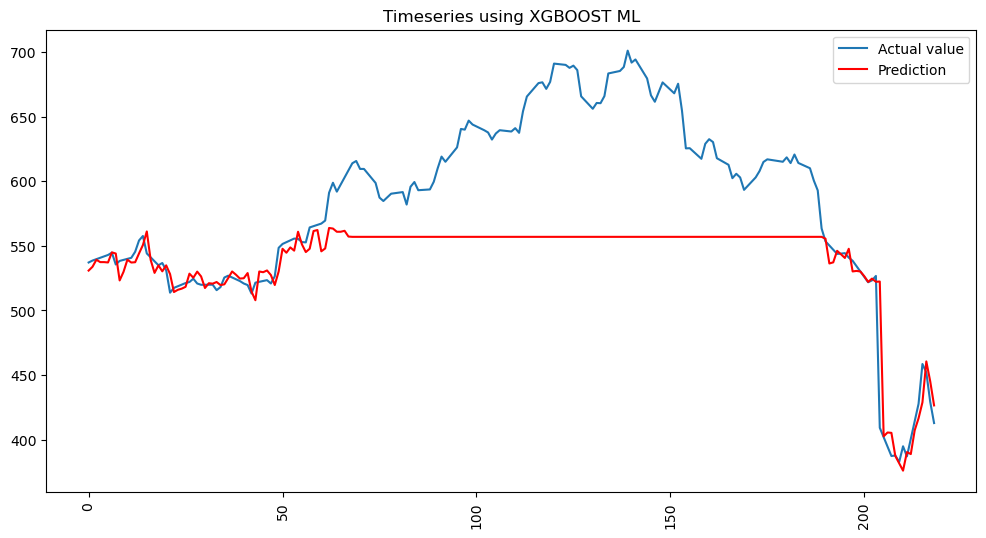

In [108]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label = 'Actual value')
plt.plot(y_pred_actual, label = 'Prediction', color = 'red')
plt.xticks(rotation = 'vertical')
plt.title('Timeseries using XGBOOST ML')
plt.legend()
plt.show()

In [109]:
mae_comparison = pd.DataFrame(
    {
        'model_name': model_names,
        'mae': mae_models
    }
)
mae_comparison

,model_name,mae
0,Sarima,59.239455
1,Auto Arima,86.592508
2,Random Forest,42.090714
3,XGBoost,47.930402


<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: center;"> <b> Model XGBoost không có sự cải thiện đáng kể so với randomforest. Nhưng nhìn chung thì sai số thấp hơn Sarima và Auto Arima <b> <div>

# 9. Time series áp dụng Deep learning

In [110]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(12, 1)))
model.add(LSTM(50, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=16, epochs=200)

Epoch 1/200


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0322
Epoch 2/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 3/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 4/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 5/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8354e-04
Epoch 6/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010
Epoch 7/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7416e-04
Epoch 8/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8976e-04
Epoch 9/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6938e-04
Epoch 10/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010
Epoch 11/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9700e-04
Epoch 12/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0811e-04
Epoch 13/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 14/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6461e-04
Epoch 15/200
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

In [111]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

y_predict = model.predict(X_test)

y_predict_actual = scaler.inverse_transform(y_predict.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

mse_lstm = mean_squared_error(y_test_actual, y_predict_actual)
mae_lstm = mean_absolute_error(y_test_actual, y_predict_actual)

mae_models.append(mae_lstm)
model_names.append('LSTM')

print('mse after inverse:', mse_lstm)
print('mae after inverse:', mae_lstm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
mse after inverse: 167.7928660763239
mae after inverse: 8.113213919954577


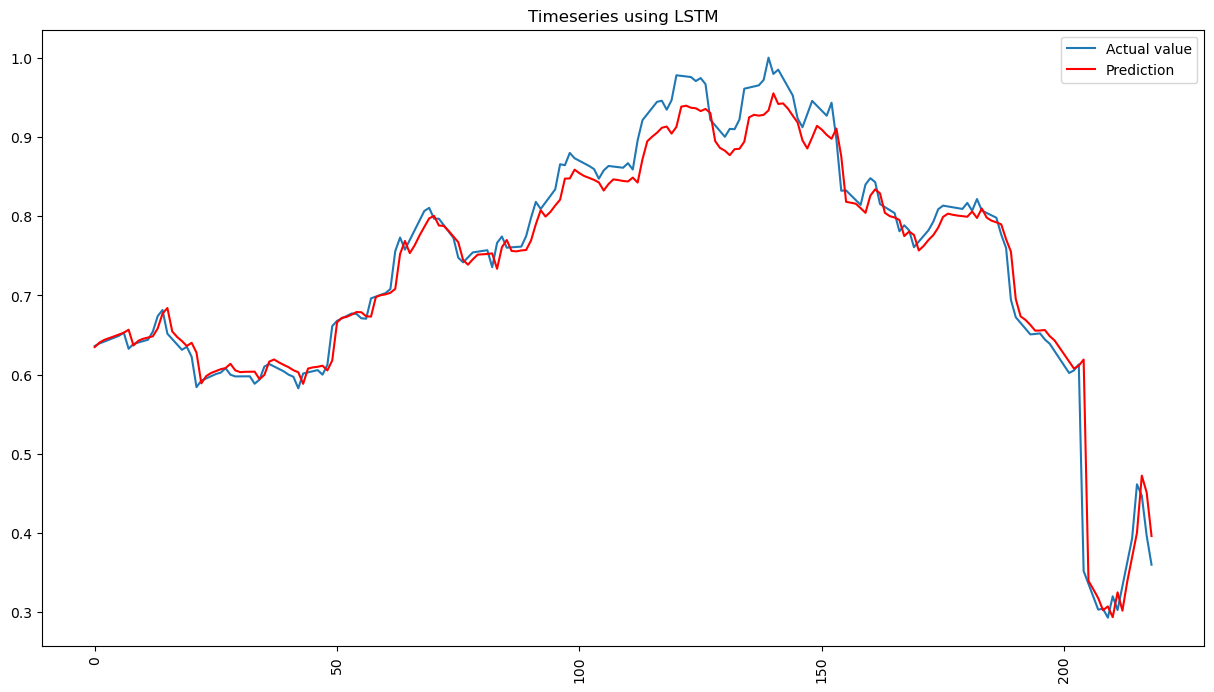

In [112]:
plt.figure(figsize=(15,8))
plt.plot(y_test, label='Actual value')
plt.plot(y_predict, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.title('Timeseries using LSTM')
plt.legend()
plt.show()

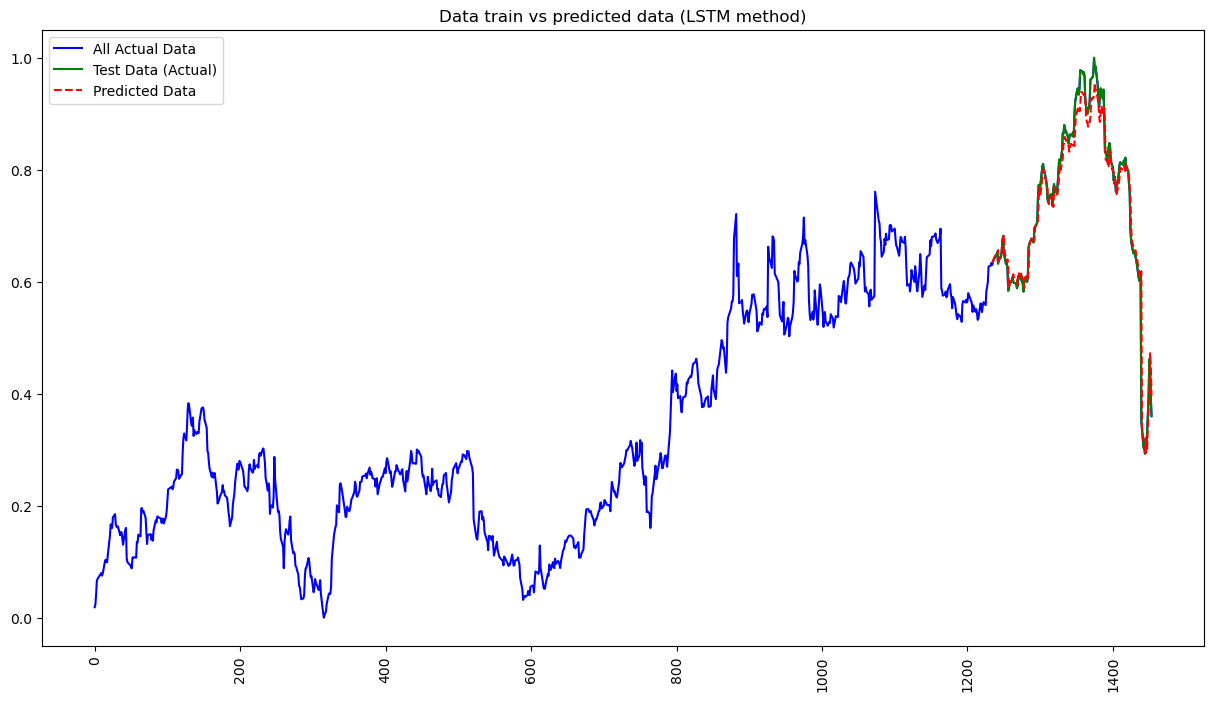

In [113]:
plt.figure(figsize=(15, 8))

# plot all actual data
plt.plot(range(len(y_train) + len(y_test)), 
         list(y_train) + list(y_test), 
         label='All Actual Data', color='blue')

# plot test data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), 
         y_test, 
         label='Test Data (Actual)', color='green')

# plot predicted data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), 
         y_predict, 
         label='Predicted Data', color='red', linestyle='--')

plt.xticks(rotation='vertical')
plt.legend()
plt.title('Data train vs predicted data (LSTM method)')
plt.show()

In [114]:
mae_comparison = pd.DataFrame(
    {
        'model_name': model_names,
        'mae': mae_models
    }
)
mae_comparison

,model_name,mae
0,Sarima,59.239455
1,Auto Arima,86.592508
2,Random Forest,42.090714
3,XGBoost,47.930402
4,LSTM,8.113214


<div class="alert alert-block alert-info" style="background-color:#FFFFFF;color:#000000;border-color:black;width:100%;margin: auto;text-align: left;"> <b>
Tiếp tục so sánh chỉ số MAE của các models

- Thuật toán deep learning LSTM có độ sai số thấp nhất (8.11), mang lại hiệu quả cao nhất

- Auto Arima có MAE cao nhất (86.59) cho thấy sự kém hiệu quả đối với tập dữ liệu này.

- Các mô hình máy học khác như RandomForest và XGBoost có MAE thấp hơn mô hình truyền thống như Sarima và auto arima <b> <div>

----- END -----